# Mission 01

Testing three different estimations of the environment



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting, reduction
import pandas

%load_ext autoreload
%autoreload 2
%matplotlib widget

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

#COLOR = 'white'
#plt.rcParams['text.color'] = COLOR
#plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['xtick.color'] = COLOR
#plt.rcParams['ytick.color'] = COLOR


In [96]:
dataset_path = '/home/berlukas/Documents/workspace/fgsp_ws/src/fgsp/data/mission_01/'
loam_file = dataset_path + 'loam_header_less.csv'
rovio_file = dataset_path + 'rovio_header_less.csv'
opt_file = dataset_path + 'opt_header_less.csv'

labels = ['ts', 'vertex-id', 'mission_id', 'p_G_Ix', 'p_G_Iy', 'p_G_Iz', 'q_G_Iw', 'q_G_Ix', 'q_G_Iy', 'q_G_Iz', 'p_M_Ix', 'p_M_Iy', 'p_M_Iz', 'q_M_Iw', 'q_M_Ix', 'q_M_Iy', 'q_M_Iz', 'v_Mx', 'v_My', 'v_Mz', 'bgx', 'bgy', 'bgz', 'bax', 'bay', 'baz']
loam_df = pandas.read_csv(loam_file, names=labels, delimiter=',', header=None)
rovio_df = pandas.read_csv(rovio_file, names=labels, delimiter=',', header=None)
opt_df = pandas.read_csv(opt_file, names=labels, delimiter=',', header=None)

print(f'\nRead {loam_df.size} (loam), {rovio_df.size} (rovio) and {opt_df.size} (opt)  entries.')


Read 55900 (loam), 57148 (rovio) and 64064 (opt)  entries.


## Synchronization of the Trajectories

Based on the timestampe we synchronize each mission to the optimized trajectory.
This helps to sparsify the graphs.

In [98]:

loam_ts = loam_df[['ts']].to_numpy()
rovio_ts = rovio_df[['ts']].to_numpy()
opt_ts = opt_df[['ts']].to_numpy()

opt_size = opt_ts.shape[0]

print(f'Processing {opt_size} optimized entries.')


loam_idx = np.zeros((opt_size, 1))
rovio_idx = np.zeros((opt_size, 1))

for i in range(0, opt_size):
    cur_ts = opt_ts[i,0]
    #print(f'cur_ts = {cur_ts}')
    
    #print(loam_ts)
    loam_ts_diff = np.absolute(loam_ts - cur_ts)    
    cur_min_loam_index = np.where(loam_ts_diff == np.amin(loam_ts_diff))[0]    
    loam_idx[i] = cur_min_loam_index[0]
    
    rovio_ts_diff = np.absolute(rovio_ts - cur_ts)
    cur_min_rovio_index = np.where(rovio_ts_diff == np.amin(rovio_ts_diff))[0]
    rovio_idx[i] = cur_min_rovio_index[0]
    

#used_idx = np.union1d(loam_idx, rovio_idx)    

Processing 2464 optimized entries.


## Graph Creation
First, create the full graph then the reduced one.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d145b1940>)

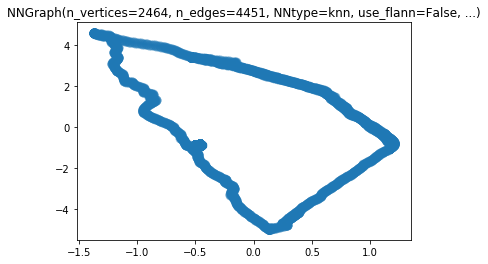

In [99]:
#loam_graph = loam_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
#rovio_graph = rovio_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
#opt_graph = opt_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()

loam_graph = loam_df[['p_G_Ix', 'p_G_Iy']].to_numpy()
rovio_graph = rovio_df[['p_G_Ix', 'p_G_Iy']].to_numpy()
opt_graph = opt_df[['p_G_Ix', 'p_G_Iy']].to_numpy()


loam_graph = loam_graph[loam_idx.astype(int),:].squeeze()
rovio_graph = rovio_graph[rovio_idx.astype(int),:].squeeze()

G = graphs.NNGraph(opt_graph, use_flann=False, k=3)
G.compute_fourier_basis()
G.plot()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d0d5e99e8>)

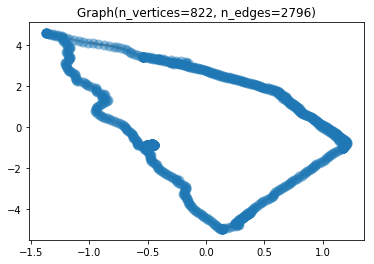

In [100]:
n_nodes = np.shape(opt_graph)[0]
ind = np.arange(0, n_nodes, 3)
Gs = reduction.kron_reduction(G, ind)
Gs.plot()

## Signal Generation
For each trajectory, create a signal that is defined on the graph. 

In [101]:
loam_origin = loam_graph[0,:]
rovio_origin = rovio_graph[0,:]
opt_origin = opt_graph[0,:]

loam_pos_signal = (loam_graph - loam_origin).squeeze()
rovio_pos_signal = (rovio_graph - rovio_origin).squeeze()
opt_pos_signal = (opt_graph - opt_origin).squeeze()

x_loam = np.linalg.norm(loam_pos_signal, ord=2, axis=1)
x_rovio = np.linalg.norm(rovio_pos_signal, ord=2, axis=1)
x_opt = np.linalg.norm(opt_pos_signal, ord=2, axis=1)

## Signal Transformation

In [102]:
# Perform high-pass filtering?

x_loam_hat = G.gft(x_loam).squeeze()
x_rovio_hat = G.gft(x_rovio).squeeze()
x_opt_hat = G.gft(x_opt).squeeze()


print(f'LOAM: $x^T L x = {G.dirichlet_energy(x_loam)}$')
print(f'ROVIO: $x^T L x = {G.dirichlet_energy(x_rovio)}$')
print(f'OPT: $x^T L x = {G.dirichlet_energy(x_opt)}$')

LOAM: $x^T L x = 190.05802786364993$
ROVIO: $x^T L x = 25547.6026743199$
OPT: $x^T L x = 150.00807850517447$


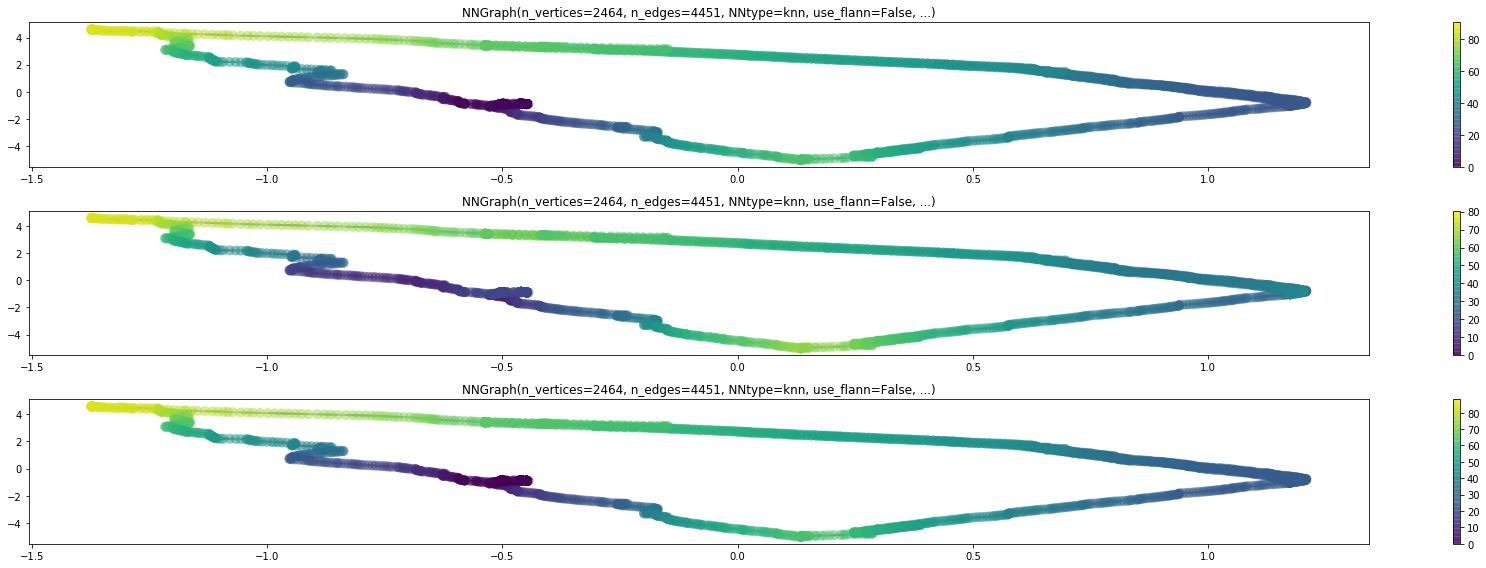

In [103]:
fig, axes = plt.subplots(3, 1, figsize=(24, 8))
fig.subplots_adjust(hspace=0.5)
G.plot(x_loam, ax=axes[0])
G.plot(x_rovio, ax=axes[1])
G.plot(x_opt, ax=axes[2])
#axes[0].set_axis_off()
fig.tight_layout()

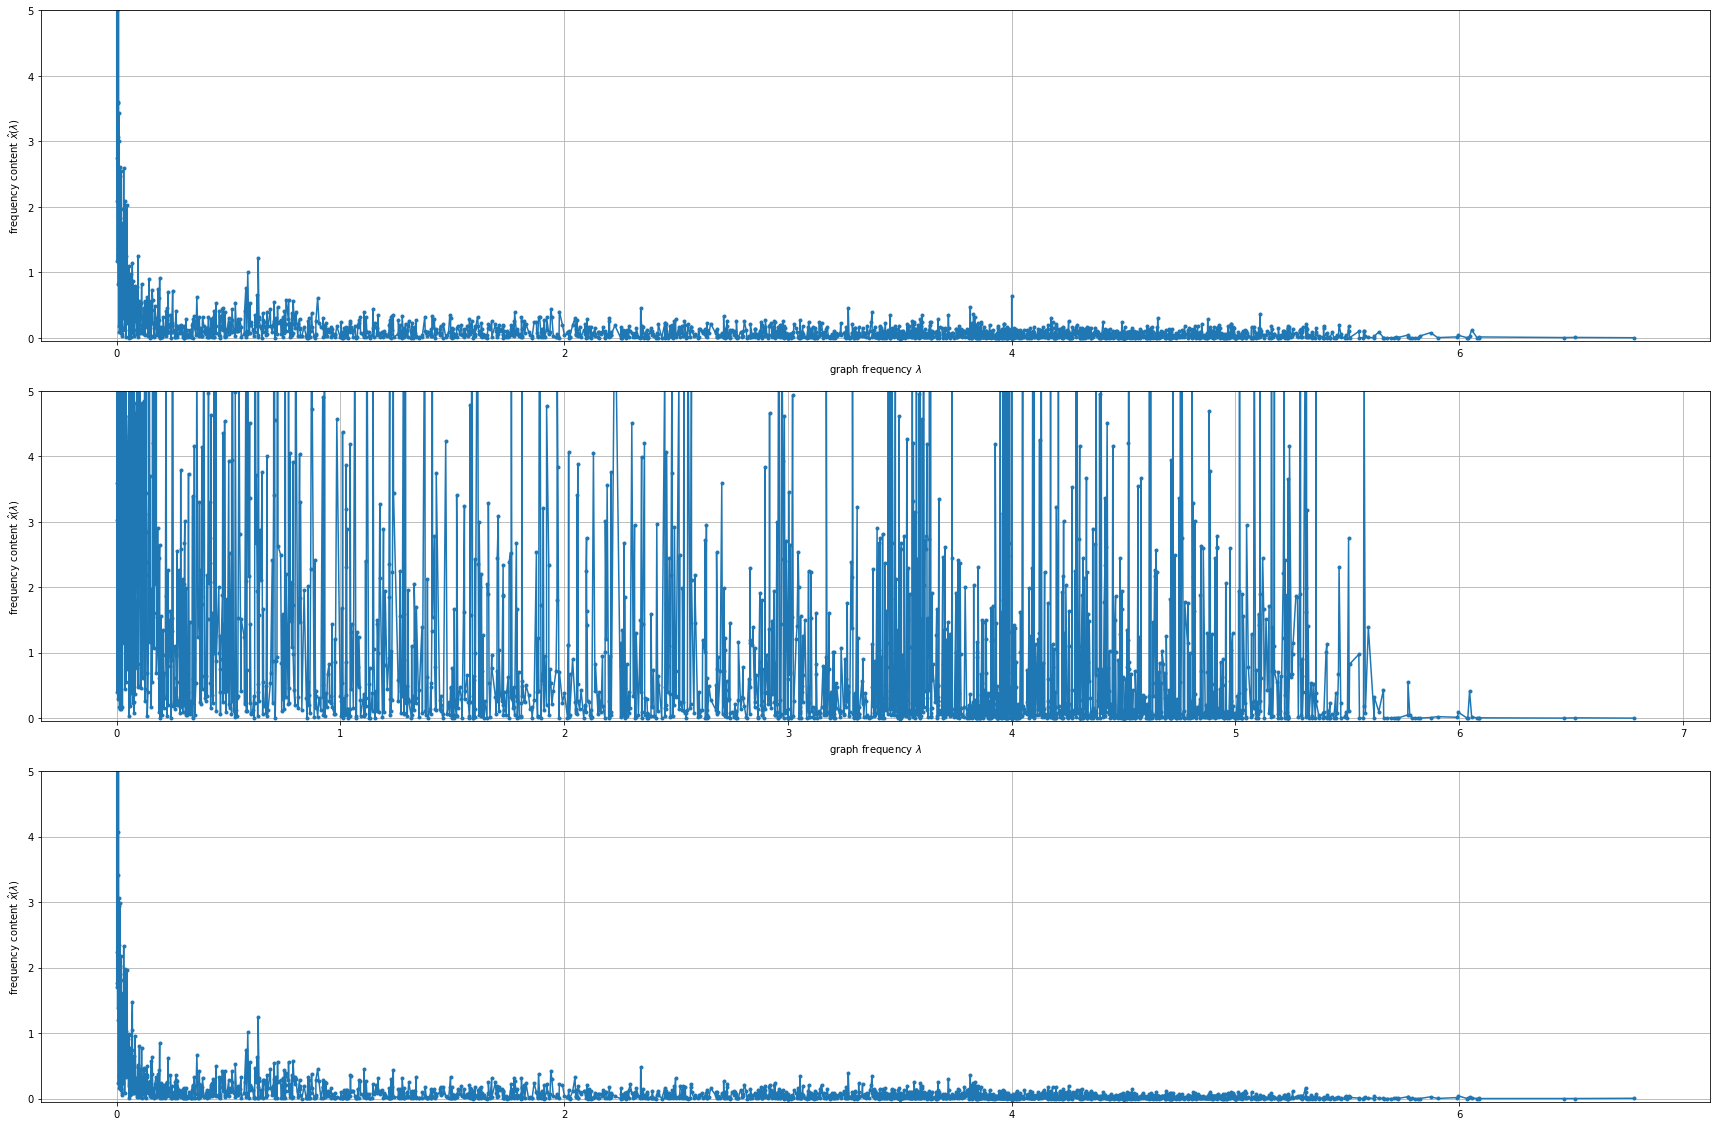

In [106]:
fig, axes = plt.subplots(3, 1, figsize=(24, 16))
fig.subplots_adjust(hspace=0.5)

axes[0].plot(G.e, np.abs(x_loam_hat), '.-')
axes[0].set_xticks(range(0, 8, 2))
axes[0].set_xlabel(r'graph frequency $\lambda$')
axes[0].set_ylim(-0.05, 5)
axes[0].set_ylabel(r'frequency content $\hat{x}(\lambda)$')
#axes[0].tick_params(axis='x', colors='white')
#axes[0].tick_params(axis='y', colors='white')
axes[0].grid()

axes[1].plot(G.e, np.abs(x_rovio_hat), '.-')
#axes[1].set_xticks(range(0, 8, 2))
axes[1].set_xlabel(r'graph frequency $\lambda$')
axes[1].set_ylim(-0.05, 5)
axes[1].set_ylabel(r'frequency content $\hat{x}(\lambda)$')
#axes[1].tick_params(axis='x', colors='white')
#axes[1].tick_params(axis='y', colors='white')
axes[1].grid()

axes[2].plot(G.e, np.abs(x_opt_hat), '.-')
axes[2].set_xticks(range(0, 8, 2))
axes[2].set_xlabel(r'graph frequency $\lambda$', color="white")
axes[2].set_ylim(-0.05, 5)
axes[2].set_ylabel(r'frequency content $\hat{x}(\lambda)$')
#axes[2].tick_params(axis='x', colors='white')
#axes[2].tick_params(axis='y', colors='white')
axes[2].grid()

fig.tight_layout()

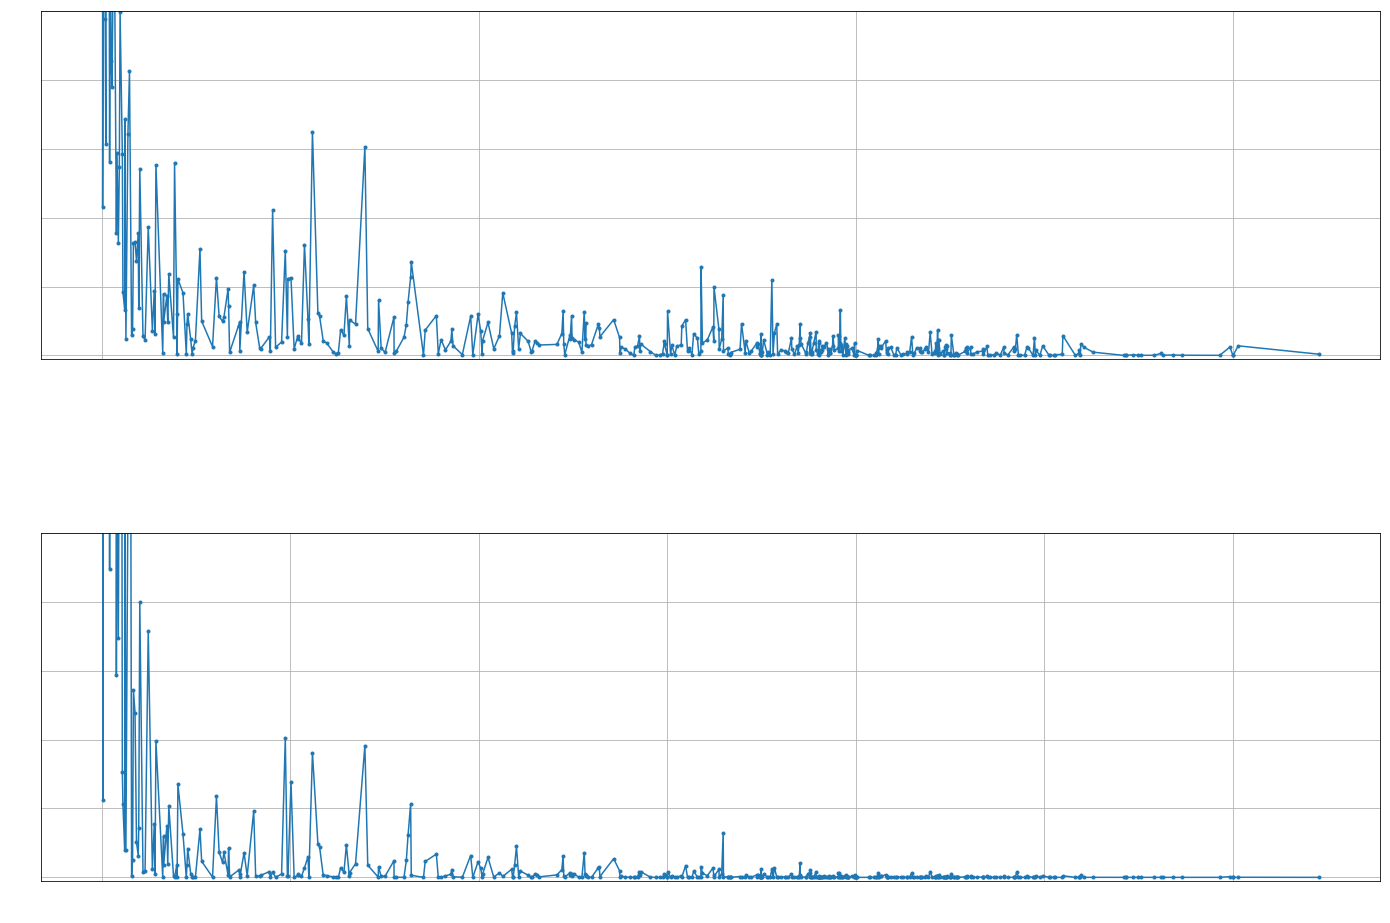

In [11]:
g = filters.Expwin(G, band_min=0.38, band_max=2)
y_rovio = g.filter(x_rovio)
y_rovio_hat = G.gft(y_rovio).squeeze()

y_rovio_hat = x_rovio_hat*x_opt_hat

fig, axes = plt.subplots(2, 1, figsize=(24, 16))
fig.subplots_adjust(hspace=0.5)

axes[0].plot(G.e, np.abs(x_rovio_hat), '.-')
axes[0].set_xticks(range(0, 8, 2))
axes[0].set_xlabel(r'graph frequency $\lambda$', color="white")
axes[0].set_ylim(-0.05, 5)
axes[0].set_ylabel(r'frequency content $\hat{x}(\lambda)$', color="white")
axes[0].tick_params(axis='x', colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].grid()

axes[1].plot(G.e, np.abs(y_rovio_hat), '.-')
axes[1].set_xlabel(r'graph frequency $\lambda$', color="white")
axes[1].set_ylim(-0.05, 5)
axes[1].set_ylabel(r'frequency content $\hat{x}(\lambda)$', color="white")
axes[1].tick_params(axis='x', colors='white')
axes[1].tick_params(axis='y', colors='white')
axes[1].grid()

In [109]:
loam_energy = (G.dirichlet_energy(s_loam[:,0]) + G.dirichlet_energy(s_loam[:,1]) + G.dirichlet_energy(s_loam[:,2]) + G.dirichlet_energy(s_loam[:,3])) / G.dirichlet_energy(x_loam)
rovio_energy = (G.dirichlet_energy(s_rovio[:,0]) + G.dirichlet_energy(s_rovio[:,1]) + G.dirichlet_energy(s_rovio[:,2]) + G.dirichlet_energy(s_rovio[:,3])) / G.dirichlet_energy(x_rovio)
opt_energy = (G.dirichlet_energy(s_opt[:,0]) + G.dirichlet_energy(s_opt[:,1]) + G.dirichlet_energy(s_opt[:,2]) + G.dirichlet_energy(s_opt[:,3])) / G.dirichlet_energy(x_opt)


print(f'LOAM: {loam_energy}')
print(f'ROVIO:{rovio_energy}')
print(f'OPT: {opt_energy}')

LOAM: 0.9422261271204599
ROVIO:0.865603870924971
OPT: 0.9591769686011057


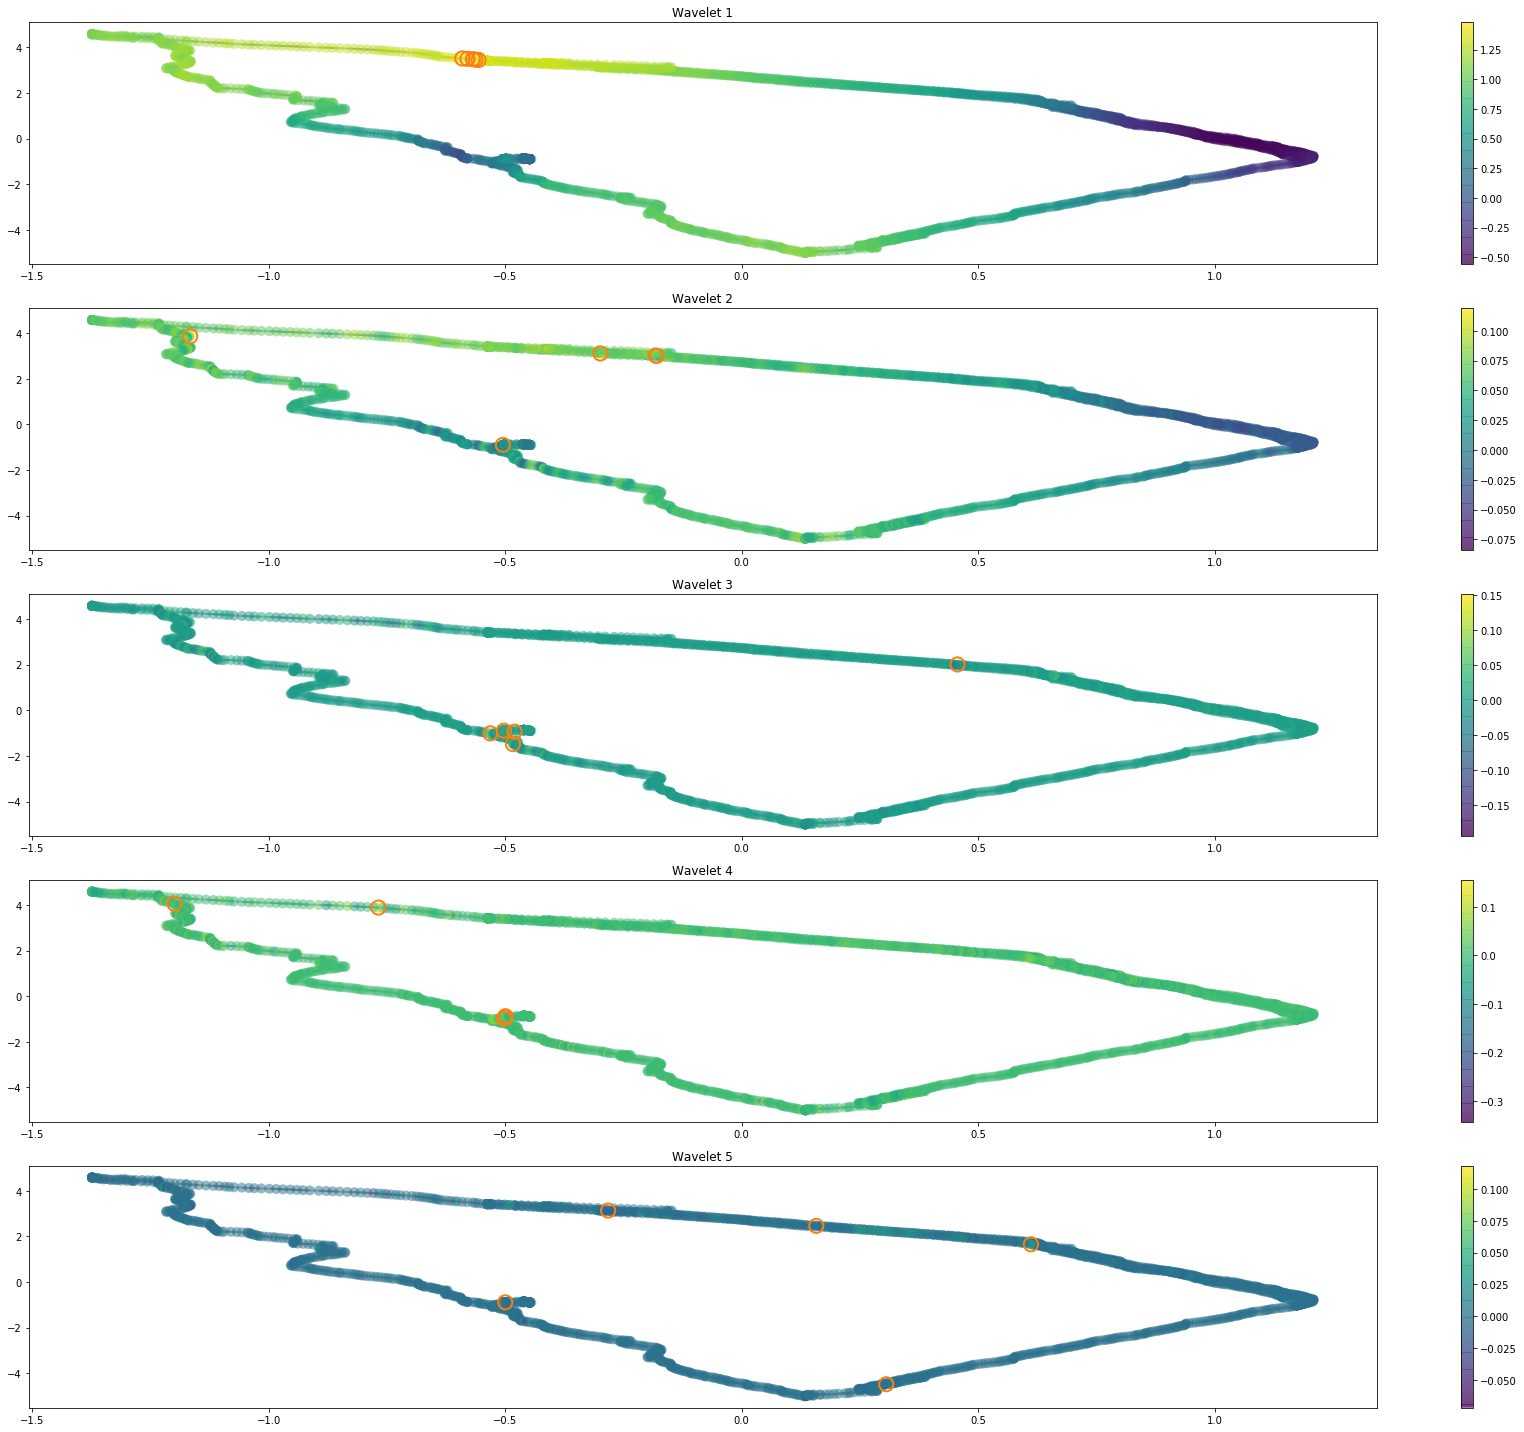

In [111]:
n_filter = 5

#g = filters.MexicanHat(G, Nf=n_filter)
g = filters.Meyer(G, Nf=n_filter)
s_rovio = g.filter(x_rovio)
s_loam = g.filter(x_loam)
s_opt = g.filter(x_opt)
#s_diff = g.filter(np.linalg.norm(x_diff, ord=2, axis=1))

s = np.zeros((s_opt.shape[0], n_filter))
#for i in range(0,n_filter):
#    s_diff = (s_rovio[:,i] - s_opt[:,i]).squeeze()   
#    s[:,i] = np.linalg.norm(s_diff, ord=2, axis=0)    

s = s_loam - s_opt
fig, axes = plt.subplots(n_filter, 1, figsize=(24, 20))
fig.subplots_adjust(hspace=0.5)
for i in range(0, n_filter):    
    w = (np.divide(x_opt_hat, x_loam_hat/x_loam_hat))
    w = 1-(w - w.min()) / (w.max() - w.min())
    
    s_level = s[:,i]
    top_n = 5
    peaks = s_level.argsort()[-top_n:][::-1]
    #print(s_level[410])
    #peaks = np.zeros((1,top_n))
    #for j in range(0, top_n):     
     #   print(top_values[j])
      #  test = np.where(s_level == top_values[j])[0]
       # print(test)
        #peaks[0,j] = test
    
    s_tmp = s[:,i] * w
    #s_tmp = (s_tmp - s_tmp.min()) / (s_tmp.max() - s_tmp.min())
    _ = G.plot(s_tmp, title='Wavelet {}'.format(i+1), ax=axes[i], highlight=peaks)    
    #_ = G.plot(s[:, i], title='Wavelet {}'.format(i+1), ax=axes[i])    
fig.tight_layout()